# OH NO

A virus is coming where 50% of the cryptopunks will have contracted a disease where they get a white spot. The code below generates the disease. Your job is as follows

1. Generate the data as below
2. Train a convolutional neural network to classify punks as diseased or not
   1. Create training and validation sets.
   2. Contrast in the sensitivity (TPR), specificity (1 - FPR) and accuracy in both sets.

In [13]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

np.random.seed(0)

In [2]:
## Open the image
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

n = 10000

finalArray = np.empty((n, 24, 24, 3))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)
    c, d = 24 * j, 24 * (j + 1)
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:]


Our doctors have determined this is the region where the lesion occurs.

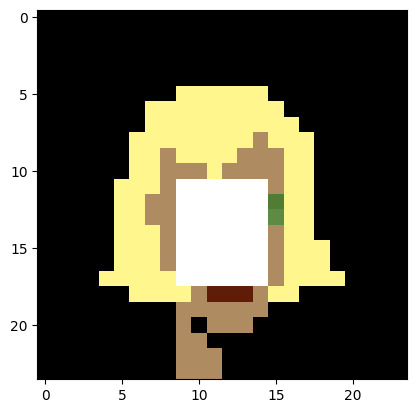

In [3]:

temp  =  finalArray[0,:,:,:].copy()

d2min, d2max = 9,14
d1min, d1max = 11,17

temp[d1min : (d1max + 1), d2min : (d2max + 1)] = 255

plt.imshow(temp.astype('uint8'))



In [4]:
cancerpunks = finalArray.copy()
label = np.zeros(n)

## Loop over the cryptopunks
for i in range(10000):
  flip = np.random.randint(0, 2)
  if flip == 1:
    label[i] = 1
    d1loc = np.random.randint(d1min, d1max + 1)
    d2loc = np.random.randint(d2min, d2max + 1)
    cancerpunks[i,d1loc,d2loc,:] = 255

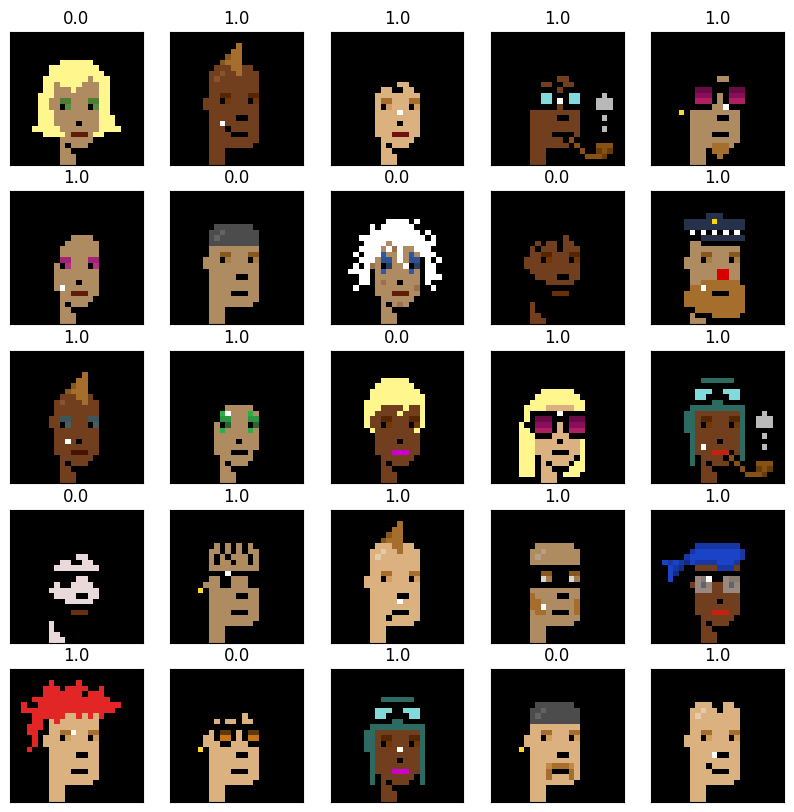

In [5]:
## plot some examples
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cancerpunks[i,:,:,:].astype('uint8'))
  plt.title(label[i])

# Exploratory Data Analysis & Preprocessing

In [7]:
# Split Training And Testing Data
n = cancerpunks.shape[0]
cancerpunks = np.reshape(cancerpunks,(n,3,24,24))
X_train, X_test, y_train, y_test = train_test_split(cancerpunks, label, train_size = 0.75)

## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print([X_train.shape, X_test.shape, y_train.shape, y_test.shape])

[(7500, 3, 24, 24), (2500, 3, 24, 24), (7500, 1), (2500, 1)]


In [8]:
trainDataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()

In [10]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    if epoch % 100 == 99:
      print(f'Epoch {epoch + 1} Loss: {running_loss:.02f}')
print('Finished Training')

Epoch 10 Loss: 50.67
Epoch 20 Loss: 45.39
Epoch 30 Loss: 35.50
Epoch 40 Loss: 27.06
Epoch 50 Loss: 20.06
Epoch 60 Loss: 16.85
Epoch 70 Loss: 9.57
Epoch 80 Loss: 11.19
Epoch 90 Loss: 8.08
Epoch 100 Loss: 6.89
Finished Training


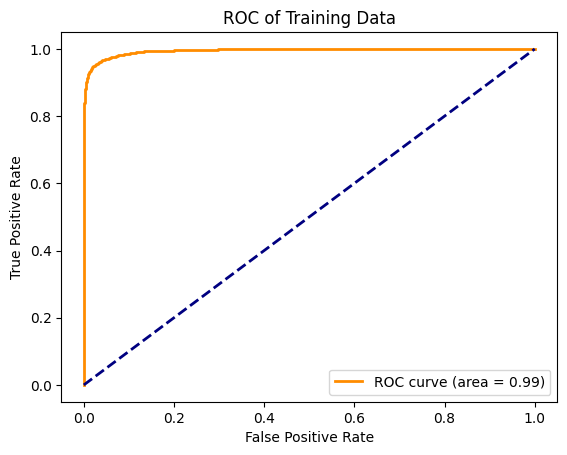

In [11]:
## Run the training data through the NN
trainout = net(torch.Tensor(X_train)).detach().numpy()

## Compare with the testing labels
fpr, tpr, thresholds = roc_curve(y_train, trainout)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Training Data')
plt.legend(loc="lower right")
plt.show()

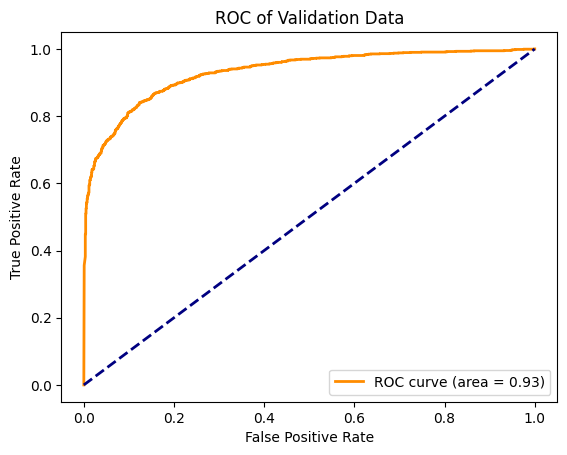

In [12]:
## Run the validation data through the NN
testout = net(torch.Tensor(X_test)).detach().numpy()

## Compare with the testing labels
fpr, tpr, thresholds = roc_curve(y_test, testout)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Validation Data')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Convert probabilities to labels
y_train_pred = np.round(trainout) # threshold = 0.50 so just round
y_test_pred = np.round(testout)

# sensitivity == recall score for binary classification
train_Sens = recall_score(y_train, y_train_pred)
test_Sens = recall_score(y_test, y_test_pred)
print(f'Training sensitivity: {train_Sens * 100:.02f}%')
print(f'Validation sensitivity: {test_Sens * 100:.02f}%\n')

# specificity == recall score of the opposite result
train_Spec = recall_score(y_train, y_train_pred, pos_label = 0)  # Use 0 as the "positive" result
test_Spec = recall_score(y_test, y_test_pred, pos_label = 0)
print(f'Training specificity: {train_Spec * 100:.02f}%')
print(f'Validation specificity: {test_Spec * 100:.02f}%\n')

# accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Training accuracy: {train_acc * 100:.02f}%')
print(f'Validation accuracy: {test_acc * 100:.02f}%\n')


Training sensitivity: 93.70%
Validation sensitivity: 80.09%

Training specificity: 98.41%
Validation specificity: 90.36%

Training accuracy: 96.07%
Validation accuracy: 85.12%

